In [1]:
# conda install -c conda-forge openexr

In [16]:
import os
import ntpath
import re

import math

import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras

#import runai.ga

#from nvidia.dali.pipeline import Pipeline
#import nvidia.dali.ops as ops
#import nvidia.dali.types as types

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils.np_utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa

import tensorflow as tf
from tensorflow.python.client import device_lib

import datetime

import cv2
import pandas as pd
import random
from IPython.display import Image
from pathlib import Path

import glob
import json
#import OpenEXR
import imageio

In [17]:
print( "Number of processors: ", multiprocessing.cpu_count() )

Number of processors:  32


In [18]:
# set to true to get more output for debugging issues
print_debug = False

# path to folder with all json files with object information
path_to_images = "C:\\tmp\\dump_truck4"
#path_to_images = "C:\\tmp\\test"


included_extensions = [ 'json' ] #, 'jpg','jpeg', 'bmp', 'png', 'gif']
obj_data_files = [ fn for fn in os.listdir( path_to_images )
                      if any( fn.endswith( ext ) for ext in included_extensions ) ]
print( "Found ", len( obj_data_files ), " json files" )

Found  1001  json files


In [19]:
def load_obj_data( jsonfile ):
    json_path = os.path.join( path_to_images, jsonfile )
    with open( json_path, 'r' ) as infile:
        data = json.load( infile )
    return data

In [20]:
def get_file_name(json_data):
    img_files_pre = json_data["frame"]["files"]
    img_files = [os.path.normpath(f) for f in img_files_pre]
    path_img           = [f for f in img_files if re.match(r'.*_img[0-9]+\.(png|jpeg|jpg)', f)][0]
    path_img_z_map     = [f for f in img_files if re.match(r'.*_z[0-9]+\.exr', f)][0]
    path_img_class     = [f for f in img_files if re.match(r'.*_class[0-9]+\.(png|jpeg|jpg)', f)][0]
    path_img_z_img     = [f for f in img_files if re.match(r'.*_z_img[0-9]+\.(png|jpeg|jpg)', f)][0]
    path_img_class_img = [f for f in img_files if re.match(r'.*_class_img[0-9]+\.(png|jpeg|jpg)', f)][0]
    return (path_img, path_img_z_map, path_img_class, path_img_z_img, path_img_class_img )

In [21]:
def img_preprocess_load( img_path ):
    img = mpimg.imread( img_path )
    img = img_preprocess( img )
    return img

In [22]:
def img_rm_alpha( img_orig ):
    img = np.copy( img_orig )
    h, w, cp = img.shape
    if cp == 4:
        for y in range( h - 1 ):
            for x in range( w - 1 ):
                img[y][x][3]=1
    return img

In [23]:
def img_rect( img_orig, rects ):
    img = img_rm_alpha( img_orig )
    h, w, cp = img.shape
    print ("H,W,CP = ", h, w, cp)
    for rect in rects:
        (p1, p2, color) = rect
        p1s = ( int(p1[0] * w), int(h - p1[1] * h) )
        p2s = ( int(p2[0] * w), int(h - p2[1] * h) )
        cv2.rectangle( img, p1s, p2s, color, 5 )
    alpha = 0.4  # Transparency factor.
    # Following line overlays transparent rectangle over the image
    img = cv2.addWeighted(img, alpha, img_orig, 1 - alpha, 0)
    return img

def rndColor():
    r = min(random.randint(0, 8) * 32, 255)
    g = min(random.randint(0, 8) * 32, 255)
    b = min(random.randint(0, 8) * 32, 255)
    return (r, g, b)

def get_bb(data, objName):
    c = rndColor()
    if print_debug:
        print ("Color for ", objName, " is ", c)

    objData = data["frame"]["objects"][objName]
    if "bb2dWithChildren" in objData:
        bb2d = objData["bb2dWithChildren"]
    elif "bb2d" in objData:
        bb2d = objData["bb2d"]
    if bb2d:
        rect = ( ( bb2d["x1"], bb2d["y1"] ), ( bb2d["x2"], bb2d["y2"] ), c )
    else:
        rect = ( ( 0, 0 ), ( 0, 0 ) )
    return rect

In [24]:
def output_bounding_box(values):
    # output debugging information about the bounding boxes
    if "bb2d" in values:
        print("{}\t{}\tbb2d=({:.2},{:.2},{:.2},{:.2})".format(keys,values["name"],values["bb2d"]["x1"],values["bb2d"]["y1"],values["bb2d"]["x2"],values["bb2d"]["y2"]) )
    if "bb2dWithChildren" in values:
        print("{}\t{}\tbb2dWC=({:.2},{:.2},{:.2},{:.2})".format(keys,values["name"],values["bb2dWithChildren"]["x1"],values["bb2dWithChildren"]["y1"],values["bb2dWithChildren"]["x2"],values["bb2dWithChildren"]["y2"]) )

In [25]:
print_debug = False

def loadFileInfo( obj_data_path ):
    #objs = [ "Cube.000", "Cube.002", "Cube.003" ]
    #objs = [ "Car Rig", "wheel.Ft.L", "wheel.Ft.R", "wheel.Bk.L", "wheel.Bk.R", "body", "Minetruck" ]
    #objs = [ "wheel.Ft.L", "wheel.Ft.R", "wheel.Bk.L", "wheel.Bk.R", "body", "Minetruck" ]
    #objs = [ "testcar-Body", "testcar-Wheel.Ft.L", "testcar-Wheel.Ft.R", "testcar-Wheel.Bk.L", "testcar-Wheel.Bk.R", "Car Rig" ]
    objs = [ "Car Rig", "wheel.Ft.L", "wheel.Ft.R", "wheel.Bk.L", "wheel.Bk.R" ]

    # load json information
    data = load_obj_data( obj_data_path )

    # load image for this description
    path_img, path_img_z_map, path_img_class, path_img_z_img, path_img_class_img = get_file_name( data )
    #if print_debug:
    print ( "Loading ", obj_data_path, " using image file ", path_img )
    img_original = mpimg.imread( path_img )

    if print_debug:
        # output debugging information about the bounding boxes
        for keys, values in data[ "frame" ][ "objects" ].items():
            output_bounding_box( values )

    # find information about the steering of the vehicle
    for keys, values in data[ "frame" ][ "objects" ][ objs[ 0 ] ][ "pose" ][ "bones" ].items():
        if values[ "name" ] == "Steering":
            steering_bone = values
        elif values[ "name" ] == "GroundSensor.Axle.Ft":
            front_axle_bone = values

    if print_debug and steering_bone:
        print( "Found steering bone: ", steering_bone[ "head" ] )
    if print_debug and front_axle_bone:
        print( "Found front axle bone: ", front_axle_bone[ "head" ] )
    steering_angle = 0.0
    if steering_bone[ "head" ][ "y" ] != 0.0:
        diff_x = steering_bone[ "head" ][ "x" ] - front_axle_bone[ "head" ][ "x" ]
        diff_y = steering_bone[ "head" ][ "y" ] - front_axle_bone[ "head" ][ "y" ]
        steering_angle = 180.0 / math.pi * math.atan( diff_x / diff_y )
    if print_debug:
        print( "steering_angle = ", steering_angle, " degree" )

    rects = [ get_bb( data, o ) for o in objs ]
    return ( steering_angle, rects, img_original )

In [26]:
# run single-threaded
objectInfos = [ loadFileInfo( n ) for n in obj_data_files ]

# run multi-threaded:
#with mp.Pool( processes = mp.cpu_count() ) as pool:
#    objectInfos = pool.map( loadFileInfo, [ n for n in obj_data_files[ :20 ] ] )

Loading  obj_data0001.json  using image file  C:\tmp\dump_truck4\minetruck_img0001.png
Loading  obj_data0002.json  using image file  C:\tmp\dump_truck4\minetruck_img0002.png
Loading  obj_data0003.json  using image file  C:\tmp\dump_truck4\minetruck_img0003.png
Loading  obj_data0004.json  using image file  C:\tmp\dump_truck4\minetruck_img0004.png
Loading  obj_data0005.json  using image file  C:\tmp\dump_truck4\minetruck_img0005.png
Loading  obj_data0006.json  using image file  C:\tmp\dump_truck4\minetruck_img0006.png
Loading  obj_data0007.json  using image file  C:\tmp\dump_truck4\minetruck_img0007.png
Loading  obj_data0008.json  using image file  C:\tmp\dump_truck4\minetruck_img0008.png
Loading  obj_data0009.json  using image file  C:\tmp\dump_truck4\minetruck_img0009.png
Loading  obj_data0010.json  using image file  C:\tmp\dump_truck4\minetruck_img0010.png
Loading  obj_data0011.json  using image file  C:\tmp\dump_truck4\minetruck_img0011.png
Loading  obj_data0012.json  using image fil

Loading  obj_data0099.json  using image file  C:\tmp\dump_truck4\minetruck_img0099.png
Loading  obj_data0100.json  using image file  C:\tmp\dump_truck4\minetruck_img0100.png
Loading  obj_data0101.json  using image file  C:\tmp\dump_truck4\minetruck_img0101.png
Loading  obj_data0102.json  using image file  C:\tmp\dump_truck4\minetruck_img0102.png
Loading  obj_data0103.json  using image file  C:\tmp\dump_truck4\minetruck_img0103.png
Loading  obj_data0104.json  using image file  C:\tmp\dump_truck4\minetruck_img0104.png
Loading  obj_data0105.json  using image file  C:\tmp\dump_truck4\minetruck_img0105.png
Loading  obj_data0106.json  using image file  C:\tmp\dump_truck4\minetruck_img0106.png
Loading  obj_data0107.json  using image file  C:\tmp\dump_truck4\minetruck_img0107.png
Loading  obj_data0108.json  using image file  C:\tmp\dump_truck4\minetruck_img0108.png
Loading  obj_data0109.json  using image file  C:\tmp\dump_truck4\minetruck_img0109.png
Loading  obj_data0110.json  using image fil

Loading  obj_data0198.json  using image file  C:\tmp\dump_truck4\minetruck_img0198.png
Loading  obj_data0199.json  using image file  C:\tmp\dump_truck4\minetruck_img0199.png
Loading  obj_data0200.json  using image file  C:\tmp\dump_truck4\minetruck_img0200.png
Loading  obj_data0201.json  using image file  C:\tmp\dump_truck4\minetruck_img0201.png
Loading  obj_data0202.json  using image file  C:\tmp\dump_truck4\minetruck_img0202.png
Loading  obj_data0203.json  using image file  C:\tmp\dump_truck4\minetruck_img0203.png
Loading  obj_data0204.json  using image file  C:\tmp\dump_truck4\minetruck_img0204.png
Loading  obj_data0205.json  using image file  C:\tmp\dump_truck4\minetruck_img0205.png
Loading  obj_data0206.json  using image file  C:\tmp\dump_truck4\minetruck_img0206.png
Loading  obj_data0207.json  using image file  C:\tmp\dump_truck4\minetruck_img0207.png
Loading  obj_data0208.json  using image file  C:\tmp\dump_truck4\minetruck_img0208.png
Loading  obj_data0209.json  using image fil

Loading  obj_data0298.json  using image file  C:\tmp\dump_truck4\minetruck_img0298.png
Loading  obj_data0299.json  using image file  C:\tmp\dump_truck4\minetruck_img0299.png
Loading  obj_data0300.json  using image file  C:\tmp\dump_truck4\minetruck_img0300.png
Loading  obj_data0301.json  using image file  C:\tmp\dump_truck4\minetruck_img0301.png
Loading  obj_data0302.json  using image file  C:\tmp\dump_truck4\minetruck_img0302.png
Loading  obj_data0303.json  using image file  C:\tmp\dump_truck4\minetruck_img0303.png
Loading  obj_data0304.json  using image file  C:\tmp\dump_truck4\minetruck_img0304.png
Loading  obj_data0305.json  using image file  C:\tmp\dump_truck4\minetruck_img0305.png
Loading  obj_data0306.json  using image file  C:\tmp\dump_truck4\minetruck_img0306.png
Loading  obj_data0307.json  using image file  C:\tmp\dump_truck4\minetruck_img0307.png
Loading  obj_data0308.json  using image file  C:\tmp\dump_truck4\minetruck_img0308.png
Loading  obj_data0309.json  using image fil

Loading  obj_data0396.json  using image file  C:\tmp\dump_truck4\minetruck_img0396.png
Loading  obj_data0397.json  using image file  C:\tmp\dump_truck4\minetruck_img0397.png
Loading  obj_data0398.json  using image file  C:\tmp\dump_truck4\minetruck_img0398.png
Loading  obj_data0399.json  using image file  C:\tmp\dump_truck4\minetruck_img0399.png
Loading  obj_data0400.json  using image file  C:\tmp\dump_truck4\minetruck_img0400.png
Loading  obj_data0401.json  using image file  C:\tmp\dump_truck4\minetruck_img0401.png
Loading  obj_data0402.json  using image file  C:\tmp\dump_truck4\minetruck_img0402.png
Loading  obj_data0403.json  using image file  C:\tmp\dump_truck4\minetruck_img0403.png
Loading  obj_data0404.json  using image file  C:\tmp\dump_truck4\minetruck_img0404.png
Loading  obj_data0405.json  using image file  C:\tmp\dump_truck4\minetruck_img0405.png
Loading  obj_data0406.json  using image file  C:\tmp\dump_truck4\minetruck_img0406.png
Loading  obj_data0407.json  using image fil

Loading  obj_data0495.json  using image file  C:\tmp\dump_truck4\minetruck_img0495.png
Loading  obj_data0496.json  using image file  C:\tmp\dump_truck4\minetruck_img0496.png
Loading  obj_data0497.json  using image file  C:\tmp\dump_truck4\minetruck_img0497.png
Loading  obj_data0498.json  using image file  C:\tmp\dump_truck4\minetruck_img0498.png
Loading  obj_data0499.json  using image file  C:\tmp\dump_truck4\minetruck_img0499.png
Loading  obj_data0500.json  using image file  C:\tmp\dump_truck4\minetruck_img0500.png
Loading  obj_data0501.json  using image file  C:\tmp\dump_truck4\minetruck_img0501.png
Loading  obj_data0502.json  using image file  C:\tmp\dump_truck4\minetruck_img0502.png
Loading  obj_data0503.json  using image file  C:\tmp\dump_truck4\minetruck_img0503.png
Loading  obj_data0504.json  using image file  C:\tmp\dump_truck4\minetruck_img0504.png
Loading  obj_data0505.json  using image file  C:\tmp\dump_truck4\minetruck_img0505.png
Loading  obj_data0506.json  using image fil

Loading  obj_data0593.json  using image file  C:\tmp\dump_truck4\minetruck_img0593.png
Loading  obj_data0594.json  using image file  C:\tmp\dump_truck4\minetruck_img0594.png
Loading  obj_data0595.json  using image file  C:\tmp\dump_truck4\minetruck_img0595.png
Loading  obj_data0596.json  using image file  C:\tmp\dump_truck4\minetruck_img0596.png
Loading  obj_data0597.json  using image file  C:\tmp\dump_truck4\minetruck_img0597.png
Loading  obj_data0598.json  using image file  C:\tmp\dump_truck4\minetruck_img0598.png
Loading  obj_data0599.json  using image file  C:\tmp\dump_truck4\minetruck_img0599.png
Loading  obj_data0600.json  using image file  C:\tmp\dump_truck4\minetruck_img0600.png
Loading  obj_data0601.json  using image file  C:\tmp\dump_truck4\minetruck_img0601.png
Loading  obj_data0602.json  using image file  C:\tmp\dump_truck4\minetruck_img0602.png
Loading  obj_data0603.json  using image file  C:\tmp\dump_truck4\minetruck_img0603.png
Loading  obj_data0604.json  using image fil

Loading  obj_data0691.json  using image file  C:\tmp\dump_truck4\minetruck_img0691.png
Loading  obj_data0692.json  using image file  C:\tmp\dump_truck4\minetruck_img0692.png
Loading  obj_data0693.json  using image file  C:\tmp\dump_truck4\minetruck_img0693.png
Loading  obj_data0694.json  using image file  C:\tmp\dump_truck4\minetruck_img0694.png
Loading  obj_data0695.json  using image file  C:\tmp\dump_truck4\minetruck_img0695.png
Loading  obj_data0696.json  using image file  C:\tmp\dump_truck4\minetruck_img0696.png
Loading  obj_data0697.json  using image file  C:\tmp\dump_truck4\minetruck_img0697.png
Loading  obj_data0698.json  using image file  C:\tmp\dump_truck4\minetruck_img0698.png
Loading  obj_data0699.json  using image file  C:\tmp\dump_truck4\minetruck_img0699.png
Loading  obj_data0700.json  using image file  C:\tmp\dump_truck4\minetruck_img0700.png
Loading  obj_data0701.json  using image file  C:\tmp\dump_truck4\minetruck_img0701.png
Loading  obj_data0702.json  using image fil

Loading  obj_data0786.json  using image file  C:\tmp\dump_truck4\minetruck_img0786.png
Loading  obj_data0787.json  using image file  C:\tmp\dump_truck4\minetruck_img0787.png
Loading  obj_data0788.json  using image file  C:\tmp\dump_truck4\minetruck_img0788.png
Loading  obj_data0789.json  using image file  C:\tmp\dump_truck4\minetruck_img0789.png
Loading  obj_data0790.json  using image file  C:\tmp\dump_truck4\minetruck_img0790.png
Loading  obj_data0791.json  using image file  C:\tmp\dump_truck4\minetruck_img0791.png
Loading  obj_data0792.json  using image file  C:\tmp\dump_truck4\minetruck_img0792.png
Loading  obj_data0793.json  using image file  C:\tmp\dump_truck4\minetruck_img0793.png
Loading  obj_data0794.json  using image file  C:\tmp\dump_truck4\minetruck_img0794.png
Loading  obj_data0795.json  using image file  C:\tmp\dump_truck4\minetruck_img0795.png
Loading  obj_data0796.json  using image file  C:\tmp\dump_truck4\minetruck_img0796.png
Loading  obj_data0797.json  using image fil

Loading  obj_data0885.json  using image file  C:\tmp\dump_truck4\minetruck_img0885.png
Loading  obj_data0886.json  using image file  C:\tmp\dump_truck4\minetruck_img0886.png
Loading  obj_data0887.json  using image file  C:\tmp\dump_truck4\minetruck_img0887.png
Loading  obj_data0888.json  using image file  C:\tmp\dump_truck4\minetruck_img0888.png
Loading  obj_data0889.json  using image file  C:\tmp\dump_truck4\minetruck_img0889.png
Loading  obj_data0890.json  using image file  C:\tmp\dump_truck4\minetruck_img0890.png
Loading  obj_data0891.json  using image file  C:\tmp\dump_truck4\minetruck_img0891.png
Loading  obj_data0892.json  using image file  C:\tmp\dump_truck4\minetruck_img0892.png
Loading  obj_data0893.json  using image file  C:\tmp\dump_truck4\minetruck_img0893.png
Loading  obj_data0894.json  using image file  C:\tmp\dump_truck4\minetruck_img0894.png
Loading  obj_data0895.json  using image file  C:\tmp\dump_truck4\minetruck_img0895.png
Loading  obj_data0896.json  using image fil

Loading  obj_data0982.json  using image file  C:\tmp\dump_truck4\minetruck_img0982.png
Loading  obj_data0983.json  using image file  C:\tmp\dump_truck4\minetruck_img0983.png
Loading  obj_data0984.json  using image file  C:\tmp\dump_truck4\minetruck_img0984.png
Loading  obj_data0985.json  using image file  C:\tmp\dump_truck4\minetruck_img0985.png
Loading  obj_data0986.json  using image file  C:\tmp\dump_truck4\minetruck_img0986.png
Loading  obj_data0987.json  using image file  C:\tmp\dump_truck4\minetruck_img0987.png
Loading  obj_data0988.json  using image file  C:\tmp\dump_truck4\minetruck_img0988.png
Loading  obj_data0989.json  using image file  C:\tmp\dump_truck4\minetruck_img0989.png
Loading  obj_data0990.json  using image file  C:\tmp\dump_truck4\minetruck_img0990.png
Loading  obj_data0991.json  using image file  C:\tmp\dump_truck4\minetruck_img0991.png
Loading  obj_data0992.json  using image file  C:\tmp\dump_truck4\minetruck_img0992.png
Loading  obj_data0993.json  using image fil

steering angle =  -7.114742047753086  for image  344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  19.45631200067956  for image  736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  -19.456314269576705  for image  104


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  -19.4563291474493  for image  25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  16.217461269427236  for image  630


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  -19.456331479125197  for image  90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  19.027588725473873  for image  698


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4
steering angle =  -13.113625562060156  for image  275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


H,W,CP =  1024 1280 4


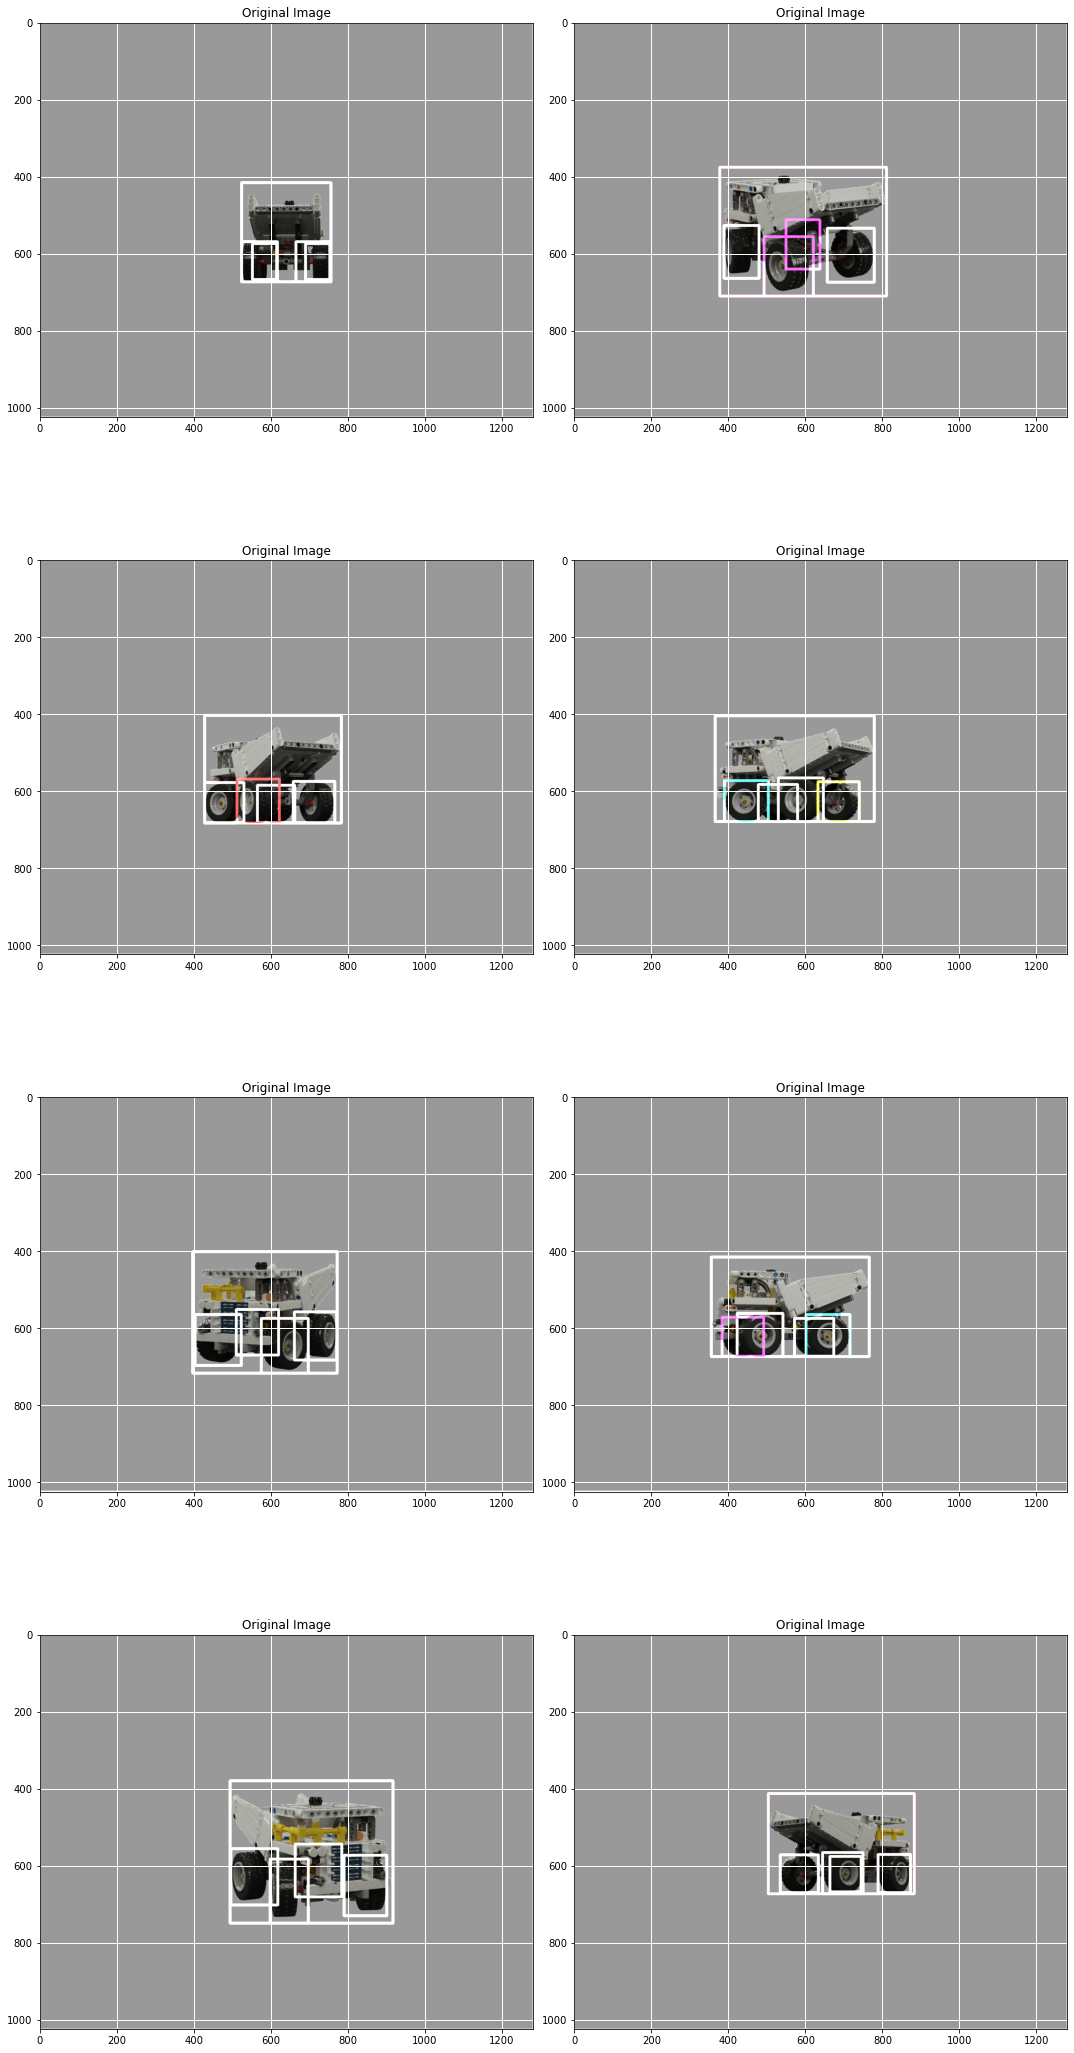

In [27]:
# draw the plots + bounding boxes
fig, axs = plt.subplots( 4, 2, figsize = ( 15, 30 ) )
fig.tight_layout()
for y in range(4):
    for x in range(2):
        obj_data_idx = random.randint( 0, len( objectInfos ) - 1 )
        ( steering_angle, bbs, img ) = objectInfos[ obj_data_idx ]
        print ( "steering angle = ", steering_angle, " for image ", obj_data_idx )
        axs[ y, x ].imshow( img_rect( img, bbs ) )
        axs[ y, x ].grid( color='w', linestyle='-', linewidth = 1 )
        axs[ y, x ].set_title( 'Original Image' )

In [28]:
image_extensions = [ 'jpg','jpeg', 'bmp', 'png', 'gif']
background_image_source_folder = "S:\\Bilder_Filme"

def get_sub_dirs( p ):
    subdirs = [ p ]
    for x in p.iterdir():
        if x.is_dir():
            subdirs = subdirs + get_sub_dirs( x )
    return subdirs


bgimg_path = Path( background_image_source_folder )
subdirs = get_sub_dirs( Path( bgimg_path ) )
img_files = []
for path in subdirs:
    print ( "Checking ", path )
    img_files = img_files + [ fn for fn in os.listdir( path ) if any( fn.endswith( ext ) for ext in image_extensions ) ]

print( "Found ", len( img_files ), " images files" )
print( "Images: ", img_files )

Checking  S:\Bilder_Filme
Checking  S:\Bilder_Filme\2009 SchauinsLandTour
Checking  S:\Bilder_Filme\2011-08 Urlaub - Tirol
Checking  S:\Bilder_Filme\2012 Liverpool
Checking  S:\Bilder_Filme\2012 Liverpool\Filme
Checking  S:\Bilder_Filme\2013 München
Checking  S:\Bilder_Filme\2013-04-12 Wanderung mit Armin und Steffen
Checking  S:\Bilder_Filme\2013-05-03 Radtour mit Martin
Checking  S:\Bilder_Filme\2014 Jahresfeier Informatik
Checking  S:\Bilder_Filme\2014 München
Checking  S:\Bilder_Filme\2014-06-18 Wandern mit Steffen
Checking  S:\Bilder_Filme\2015 MxSnow
Checking  S:\Bilder_Filme\2015 MxSnow\2015-Ischgl
Checking  S:\Bilder_Filme\2015 MxSnow\2015-Ischgl alles
Checking  S:\Bilder_Filme\2015 MxSnow\2015-Ischgl alles\mxsnow2015
Checking  S:\Bilder_Filme\2015 MxSnow\2015-Ischgl alles\mxsnow2015\dokumente
Checking  S:\Bilder_Filme\2015 MxSnow\2015-Ischgl alles\mxsnow2015\fotos
Checking  S:\Bilder_Filme\2015 MxSnow\2015-Ischgl alles\mxsnow2015\musik
Checking  S:\Bilder_Filme\2015 MxSnow\201

Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie (84)\DSC07943_44___51.data\SelectivePainter
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie (85)
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie (85)\DSC07952_53___60.data
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie (85)\DSC07952_53___60.data\SelectivePainter
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie (86)
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie (86)\DSC07961_2_3_4_5_6_7_8_9.data
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie (86)\DSC07961_2_3_4_5_6_7_8_9.data\SelectivePainter
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie (87)
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie (87)\DSC07970_1_2_3_4_5_6_7_8.data
Checking  S:\Bilder_Filme\2018-06 Urlaub Nesselried\HDR\hdr01 - Kopie (87)\DSC07970_1_2_3_4_5_6_7_8.data\SelectivePain

Checking  S:\Bilder_Filme\2020-01-06 Hornisgrinde\timelapse
Checking  S:\Bilder_Filme\2020-01-06 Hornisgrinde\timelapse_a6500
Checking  S:\Bilder_Filme\2020-02-07 Altschlossfelsen
Checking  S:\Bilder_Filme\2020-03-01 Schwetzingen
Checking  S:\Bilder_Filme\2020-03-15 Geburtstagsfeier Manfred
Checking  S:\Bilder_Filme\2020-03-15 Geburtstagsfeier Manfred\kati
Checking  S:\Bilder_Filme\2020-03-15 Geburtstagsfeier Manfred\raw
Checking  S:\Bilder_Filme\2020-04-04 Hohlohturm
Checking  S:\Bilder_Filme\2020-04-04 Hohlohturm\raw
Checking  S:\Bilder_Filme\2020-06-20 Joe und Katzen
Checking  S:\Bilder_Filme\2020-06-20 Joe und Katzen\RAW
Checking  S:\Bilder_Filme\2020-07-03 Geburtstag Wolle
Checking  S:\Bilder_Filme\2020-07-03 Geburtstag Wolle\raw
Checking  S:\Bilder_Filme\2020-07-12 Leininger Burgweg
Checking  S:\Bilder_Filme\2020-07-12 Leininger Burgweg\raw
Checking  S:\Bilder_Filme\2020-07-18 Meteor Neowise und Milchstrasse auf Hornisgrinde
Checking  S:\Bilder_Filme\2020-07-18 Meteor Neowise und

In [ ]:
# img_files
# * load some images
# * write function to add random background image to a given object image detection
# * testing
# * ... (move forward to AI training)